In [164]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

In [165]:
img_size=24

In [166]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if 'g' in f]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            i = skimage.data.imread(f)
            
            if len(i.shape) == 3:
                images.append(i)
                labels.append(int(d))
                
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "/home/theo/dev/ws/python/tf"
train_data_dir = os.path.join(ROOT_PATH, "train")
test_data_dir = os.path.join(ROOT_PATH, "test")

images, labels = load_data(train_data_dir)

In [167]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 5
Total Images: 47


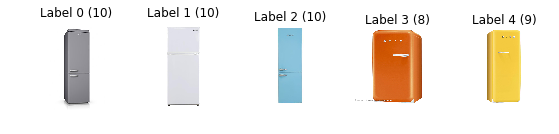

In [168]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

/home/theo/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


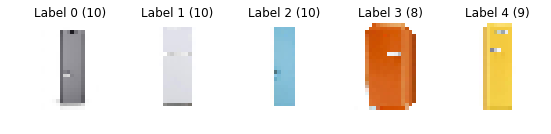

In [169]:
# Resize images
images64 = [skimage.transform.resize(image, (img_size, img_size))
                for image in images]
display_images_and_labels(images64, labels)

In [170]:
labels_a = np.array(labels)
images_a = np.array(images64)

In [171]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, img_size, img_size, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))
    
    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 1728), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [173]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [174]:
for i in range(20000):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 1000 == 0:
        print("Loss: ", loss_value)

Loss:  4.4641423
Loss:  0.89260906
Loss:  0.882341
Loss:  0.87985677
Loss:  0.8789823
Loss:  0.8785874
Loss:  0.8783911
Loss:  0.8782822
Loss:  0.87821585
Loss:  0.8781702
Loss:  0.87816083
Loss:  0.8781955
Loss:  0.8781254
Loss:  0.8781211
Loss:  0.87811834
Loss:  0.8781171
Loss:  0.87811595
Loss:  0.8781154
Loss:  0.87811506
Loss:  0.8781148


In [175]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images64) ), 10)

sample_images = [images64[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[2, 3, 0, 4, 1, 0, 0, 4, 4, 1]
[2 3 0 4 1 0 0 4 4 1]


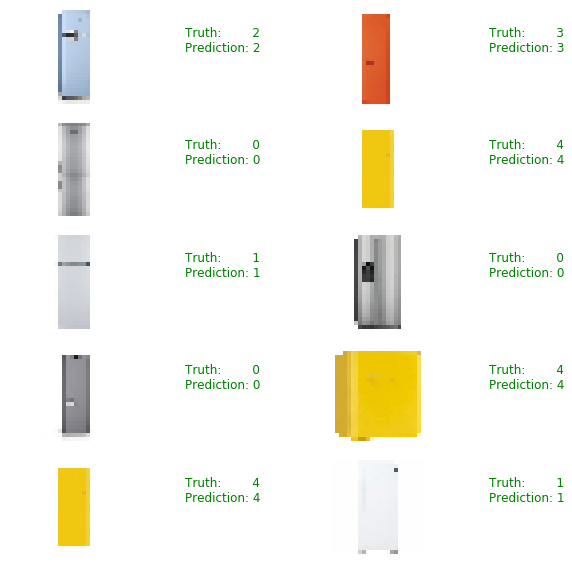

In [176]:
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [177]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

In [178]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (img_size, img_size))
                 for image in test_images]

/home/theo/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [179]:

# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]

# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])


accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.882


In [184]:
# Pick 10 random images
sample_indexes = random.sample(range(len(test_images32) ), 15)

sample_images = [test_images32[i] for i in sample_indexes]
sample_labels = [test_labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[2, 3, 1, 1, 1, 2, 3, 2, 3, 1, 3, 0, 1, 4, 0]
[2 3 1 1 1 2 3 2 3 1 3 1 1 4 0]


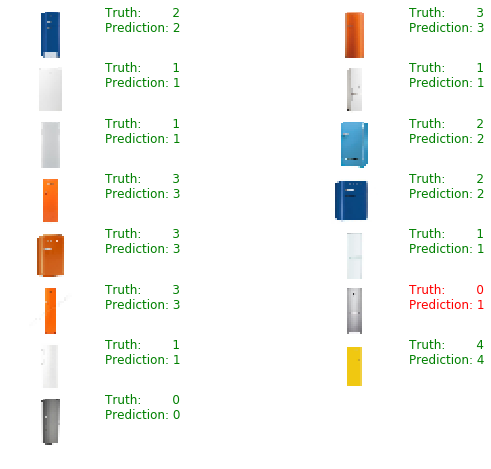

In [185]:
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(10, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])